In [1]:
%load_ext autoreload
%autoreload 2    
%matplotlib inline

In [2]:

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import numpy as np
import glob
from PIL import Image, ExifTags

# pip install torchsummary
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from time import time
import pandas as pd
import random

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

In [3]:
img_size = 1024

train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                           )
)

In [4]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


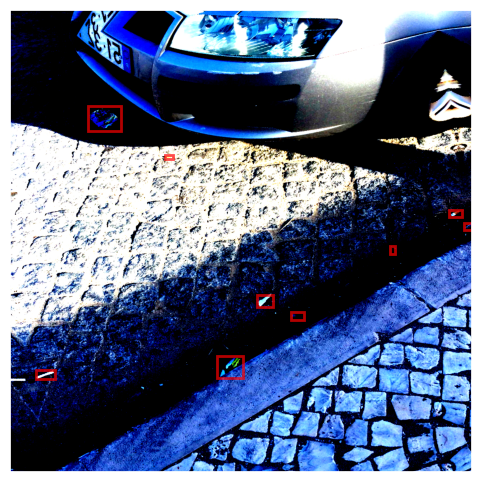

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


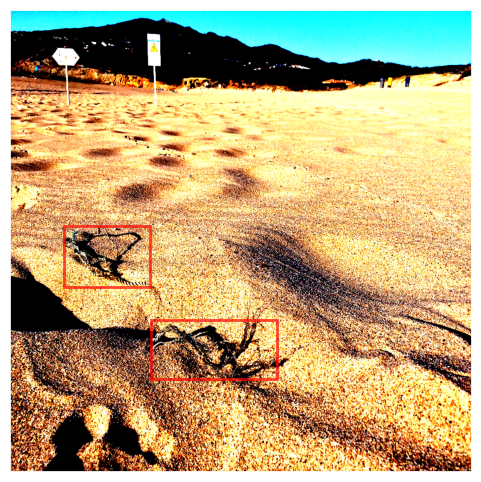

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


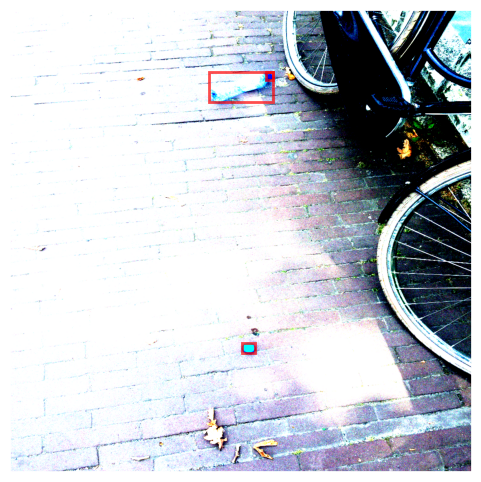

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


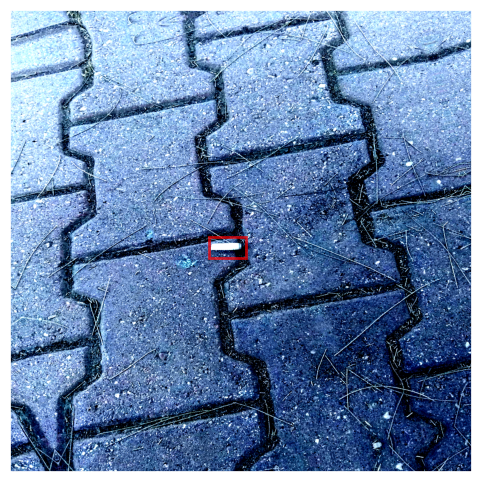

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


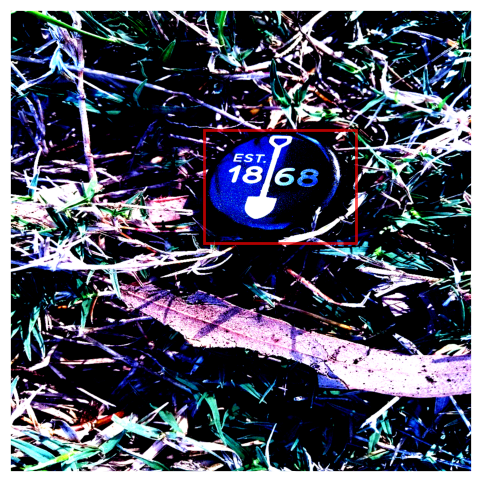

In [5]:
for img_idx in [161, 100, 200, 300, 500]:
        
    image, bboxes, labels = trainset.__getitem__(img_idx)
    
    fig,ax = plt.subplots(1)
    
    plt.imshow(image.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    
    # Show annotations
    for ann in bboxes:
        [x, y, x1, y1] = ann
        rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='red',
                         facecolor='none', alpha=0.7)
        ax.add_patch(rect)
    #plt.savefig(f'imgs/output_{img_idx}.png')
    plt.show()

In [6]:
image, bboxes, labels = trainset[5]
bboxes = [list(ele) for ele in bboxes]
bboxes = torch.FloatTensor(bboxes)
order = bboxes.argsort()
print(bboxes[:, 0])
print(bboxes)
print(order[-1])
print(len(bboxes))

tensor([419.8444, 559.6102, 576.8005, 606.8179, 800.1645])
tensor([[419.8444, 463.8741, 673.6625, 673.8070],
        [559.6102, 386.7151, 619.2919, 434.8570],
        [576.8005, 485.9962, 643.4851, 522.2728],
        [606.8179, 741.2220, 691.7832, 775.1423],
        [800.1645, 597.2720, 848.5399, 657.6926]])
tensor([1, 3, 0, 2])
5


In [7]:
rand_vals = (torch.rand(1,4)-0.5)*20
print(rand_vals)
print(f"Before: {bboxes[0]}, after {bboxes[0]+rand_vals}")
bboxes = torch.cat((bboxes,bboxes[0]+rand_vals),0)
NonMaxSuppress(bboxes, thresh_iou = 0.5)

tensor([[ 1.7095,  5.3866, -1.2891,  9.1977]])
Before: tensor([419.8444, 463.8741, 673.6625, 673.8070]), after tensor([[421.5539, 469.2607, 672.3734, 683.0047]])


[tensor([421.5539, 469.2607, 672.3734, 683.0047]),
 tensor([800.1645, 597.2720, 848.5399, 657.6926]),
 tensor([606.8179, 741.2220, 691.7832, 775.1423]),
 tensor([576.8005, 485.9962, 643.4851, 522.2728]),
 tensor([559.6102, 386.7151, 619.2919, 434.8570])]

In [8]:
IoU(bboxes[0], bboxes[0]+rand_vals)
# 0.0274

RuntimeError: Boolean value of Tensor with more than one value is ambiguous